# Initialization

In [1]:
# %load init.ipy
# NOTE: This is for when the notebook is converted to a python script
# NOTE: this MUST precede the magic functions
def get_ipython():
    return type('Dummy', (object,), dict(run_line_magic=lambda *args, **kwargs: None))
    
%reload_ext autoreload
%autoreload 2

# %load init.ipy
import os, sys, logging, datetime
from importlib import reload

import numpy as np
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from nose import tools

import corner
import tqdm
import memory_profiler as mpro

import kalepy as kale
import kalepy.utils
import kalepy.plot
from kalepy.plot import nbshow   # NOTE: this should be upgraded to `plot_control`
from kalepy.plot import plot_control

def save_fig(fig, fname, **kwargs):
    kwargs.setdefault('path', kale._PATH_NB_OUT)
    kwargs.setdefault('rename', True)
    return kale.plot.save_fig(fig, fname, **kwargs)

# Basic Usage

Generate some random-ish data

In [13]:
NUM = int(1e3)
np.random.seed(12345)
a1 = np.random.normal(4.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=(NUM - a1.size))
data = np.concatenate([a1, a2])

## Plotting smooth PDFs

Initialize the KDE class using our data to estimate the underlying Probability Distribution (Function) which describes the data.

In [15]:
kde = kale.KDE(data)

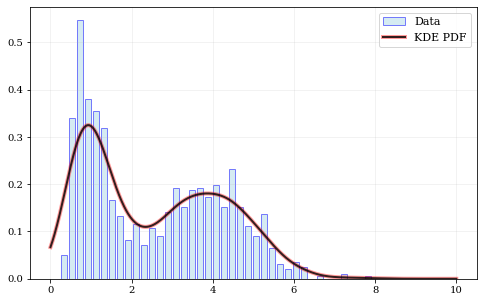

In [3]:
kde = kale.KDE(data)
grid = np.linspace(0.0, 10.0, 1000)
pdf = kde.pdf(grid)

edges = kale.utils.spacing(data, 'lin', 40)

fig, ax = plt.subplots(figsize=[8, 5])
ax.grid(alpha=0.2)
*_, pats = ax.hist(data, bins=edges, density=True, color='lightblue', edgecolor='blue', rwidth=0.8, alpha=0.5)

l1, = ax.plot(grid, pdf, 'r-', lw=4.0, alpha=0.4)
l2, = ax.plot(grid, pdf, 'k-', lw=2.0, alpha=0.8)

lines = [pats[0], (l1, l2)]
names = ['Data', 'KDE PDF']
plt.legend(lines, names, loc='upper right', fontsize=11)
nbshow()

## Constructing statistically similar values

Draw a new sample of data-points from the KDE PDF

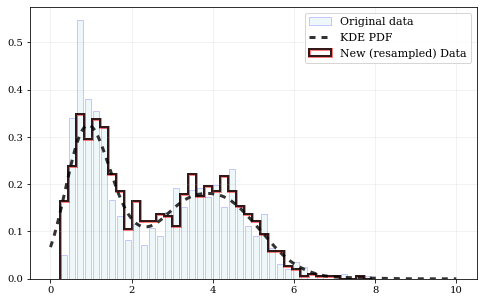

In [4]:
samples = kde.resample()

fig, ax = plt.subplots(figsize=[8, 5])
ax.grid(alpha=0.2)

*_, h0 = ax.hist(data, bins=edges, density=True, color='lightblue', edgecolor='blue', rwidth=0.8, alpha=0.2)

l1, = ax.plot(grid, pdf, 'k', ls=(0, [2, 2]), lw=3.0, alpha=0.8, label='KDE PDF')

*_, h1 = ax.hist(samples, bins=edges, density=True, color='r', histtype='step', rwidth=0.8, alpha=0.5, lw=3.0)
*_, h2 = ax.hist(samples, bins=edges, density=True, color='k', histtype='step', rwidth=0.8, alpha=0.8, lw=2.0)

lines = [h0[0], l1, (h1[0], h2[0])]
names = ['Original data', 'KDE PDF', 'New (resampled) Data']
plt.legend(lines, names, loc='upper right', fontsize=11)

nbshow()

We can continue to draw an arbitrary number of new data points, and the overall distribution perfectly follows the KDE PDF

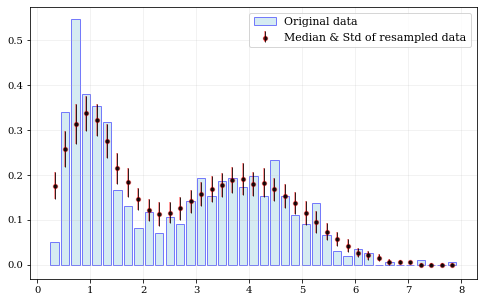

In [5]:
neff = int(kde.neff)
nreals = 100
samples = kde.resample(neff*nreals).reshape(nreals, neff)
hists = [np.histogram(samp, bins=edges, density=True)[0] for samp in samples]

fig, ax = plt.subplots(figsize=[8, 5])
ax.grid(alpha=0.2)
*_, h0 = ax.hist(data, bins=edges, density=True, color='lightblue', edgecolor='blue', rwidth=0.8, alpha=0.5)

cents = kale.utils.midpoints(edges, 'lin')
med = np.median(hists, axis=0)
std = np.std(hists, axis=0)
# ax.step(cents, med, 'r-', lw=4.0, alpha=0.4)
# ax.step(cents, med, 'k-', lw=2.0, alpha=0.8)
s0 = ax.scatter(cents, med, color='r', s=20.0, alpha=0.4, zorder=10)
s1 = ax.scatter(cents, med, color='k', s=10.0, alpha=0.8, zorder=10)
e0 = ax.errorbar(cents, med, yerr=std, fmt='none', color='r', lw=2.0, alpha=0.4)
e1 = ax.errorbar(cents, med, yerr=std, fmt='none', color='k', lw=1.0, alpha=0.8)

lines = [h0[0], (s0, s1, e0, e1)]
names = ['Original data', 'Median & Std of resampled data']
plt.legend(lines, names, fontsize=11)
nbshow()

# Multivariate Distributions

Generate some random-ish, 2D data

In [6]:
NUM = 3000
# bandwidth = 0.2

sigma = [2.5, 1.5]
corr = 0.9

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]
cov = np.array(cov)

data_1 = np.random.multivariate_normal([1.0, 2.0], cov, NUM).T

sigma = [2.5, 0.5]
corr = 0.0

s2 = np.square(sigma)
cc = corr*sigma[0]*sigma[1]
cov = [[s2[0], cc], [cc, s2[1]]]
cov = np.array(cov)
data_2 = np.random.multivariate_normal([1.0, 6.0], cov, NUM).T

data = np.concatenate([data_1, data_2], axis=-1)

Construct the KDE 

In [7]:
bandwidth = 0.2
kde = kale.KDE(data, bandwidth=bandwidth)

Plot the Bivariate PDF, and projections in each dimension

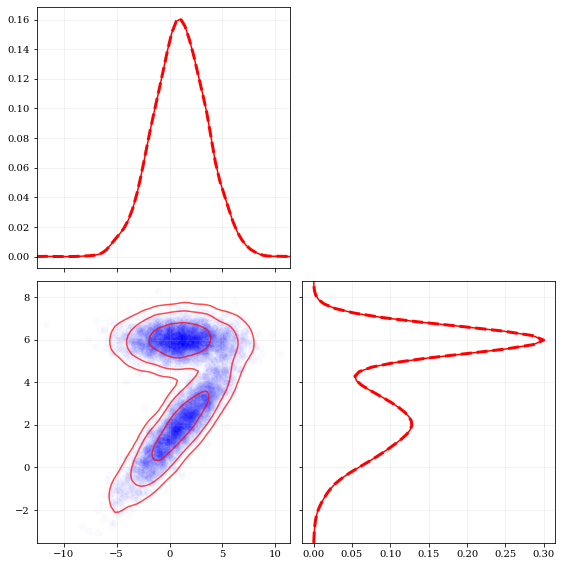

Saved to '/Users/lzkelley/Programs/kalepy/kalepy/notebooks/output/2d_pdf_projection_18.png'


'/Users/lzkelley/Programs/kalepy/kalepy/notebooks/output/2d_pdf_projection_18.png'

In [8]:
edges = [kale.utils.spacing(dd, 'lin', 60, stretch=0.1) for dd in data]
cents = [kale.utils.midpoints(ee, 'lin') for ee in edges]
widths = [np.diff(ee) for ee in edges]
area = widths[0][:, np.newaxis] * widths[1][np.newaxis, :]

xe, ye = np.meshgrid(*edges, indexing='ij')
xc, yc = np.meshgrid(*cents, indexing='ij')
grid = np.vstack([xc.ravel(), yc.ravel()])

hist, *_ = np.histogram2d(*data, bins=edges, density=True)
levels = kale.utils.spacing(hist[hist > 0], 'log', 4)

fig, axes = plt.subplots(figsize=[8, 8], ncols=2, nrows=2, sharex='col', sharey='row')
plt.subplots_adjust(left=0.08, bottom=0.05, top=0.98, right=0.98, hspace=0.05, wspace=0.05)

for (ii, jj), ax in np.ndenumerate(axes):
    if ii == 0 and jj == 1:
        ax.set_visible(False)
        continue
    
    ax.grid(alpha=0.2)
        

ax = axes[1, 0]
ax.scatter(*data, alpha=0.02, color='b')

pdf = kde.pdf(grid).reshape(hist.shape).T
ax.contour(xc, yc, pdf.T, levels=levels, colors='r', alpha=0.7)

for par in range(2):
    ax = axes[par, par]
    xx = cents[par]
    pdf_2d = kde.pdf(xx, params=par)
    kde_1d = kale.KDE(data[par, :], bandwidth=bandwidth)
    pdf_1d = kde_1d.pdf(xx)
    kale.utils.allclose(pdf_2d, pdf_1d, rtol=1e-3)
    
    for pdf, ls, lw in zip([pdf_2d, pdf_1d], ['-', '--'], [1.5, 3.0]):

        tot = np.sum(pdf*widths[par])
        kale.utils.allclose(tot, 1.0, rtol=1e-2)
        vals = [xx, pdf]
        if par == 1:
            vals = vals[::-1]

        ax.plot(*vals, color='r', ls=ls, lw=lw)
    
nbshow()

fname = '2d_pdf_projection.png'
save_fig(fig, fname)
# print("saved to '{}'".format(os.path.abspath(fname)))

# The need for a KDE

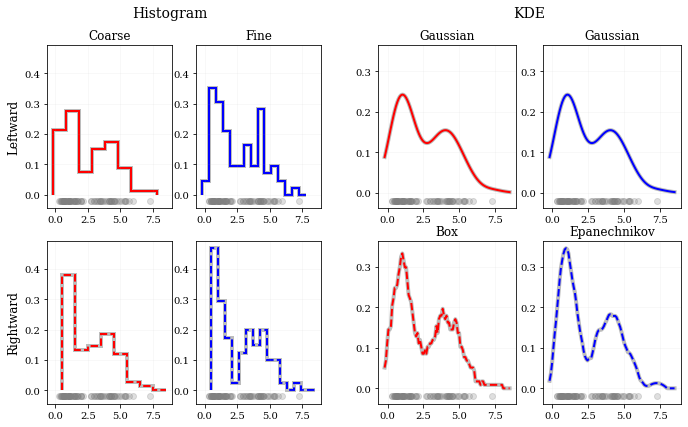

Saved to '/Users/lzkelley/Programs/kalepy/kalepy/notebooks/output/kde_motivation_18.png'


'/Users/lzkelley/Programs/kalepy/kalepy/notebooks/output/kde_motivation_18.png'

In [9]:
# Setup Figure and Axes
# --------------------------------------
fig = plt.figure(figsize=[10, 6])

# ---- Left Axes
gsl = mpl.gridspec.GridSpec(2, 2)
gsl.update(left=0.08, right=0.46, wspace=0.2, hspace=0.2, top=0.9, bottom=0.07)
axes_ll = np.empty([2, 2], dtype=object)
ax_ref = None
for (ii, jj), ax in np.ndenumerate(axes_ll):
    kw = dict(sharex=ax_ref, sharey=ax_ref) if ax_ref is not None else {}
    ax = plt.subplot(gsl[ii, jj], **kw)
    ax.grid(alpha=0.1)
    axes_ll[ii, jj] = ax
    ax_ref = ax

fig.text(0.25, 0.99, "Histogram", horizontalalignment='center', verticalalignment='top', size=14)
axes_ll[0, 0].set_ylabel('Leftward', size=12)
axes_ll[0, 0].set_title('Coarse', size=12)
axes_ll[0, 1].set_title('Fine', size=12)
axes_ll[1, 0].set_ylabel('Rightward', size=12)

# ---- Right Axes
gsr = mpl.gridspec.GridSpec(2, 2)
gsr.update(left=0.54, right=0.96, wspace=0.2, hspace=0.2, top=0.9, bottom=0.07)
axes_rr = np.empty([2, 2], dtype=object)
ax_ref = None
for (ii, jj), ax in np.ndenumerate(axes_ll):
    kw = dict(sharex=ax_ref, sharey=ax_ref) if ax_ref is not None else {}
    ax = plt.subplot(gsr[ii, jj], **kw)
    ax.grid(alpha=0.1)
    axes_rr[ii, jj] = ax
    ax_ref = ax

fig.text(0.75, 0.99, "KDE", horizontalalignment='center', verticalalignment='top', size=14)

colors = ['r', 'b', 'r', 'b']
lines = ['-', '-', '--', '--']
    

# Create (semi-)Random Data
# --------------------------------------
NUM = 80
np.random.seed(12345)
a1 = np.random.normal(4.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=(NUM - a1.size))
data = np.concatenate([a1, a2])



# Plot Histograms
# ---------------------------------
bg = dict(color='0.25', lw=4.0, alpha=0.35)

starts = [-0.2, -0.2, 0.5, 0.5]
numbers = [9, 16, 9, 16]

for ii, ax in enumerate(axes_ll.flatten()):
    edges = np.linspace(starts[ii], starts[ii]+8.0, numbers[ii])

    ax.hist(data, bins=edges, histtype='step', density=True, **bg)
    ax.hist(data, bins=edges, color=colors[ii], density=True, ls=lines[ii],
            histtype='step', lw=2.0)
    
    ax.plot(data, -0.02*np.ones_like(data), 'o', color='0.5', alpha=0.25, lw=0.5)

    
    
# Plot KDEs
# ---------------------------------

# bandwidths = ['scott', 0.3, 'scott', 0.3]
kernels = ['Gaussian', 'Gaussian', 'Box', 'Epanechnikov']
# kernels = ['Gaussian', 'Parabola', 'Box', 'Triweight']

bandwidths = [None] * len(kernels)
grid = np.linspace(-0.2, 8.5, 100)

for ii, ax in enumerate(axes_rr.flatten()):
    kde = kale.KDE(data, kernel=kernels[ii], bandwidth=bandwidths[ii])
    ax.set_title(kernels[ii])
    pdf = kde.pdf(grid)
    ax.plot(grid, pdf, **bg)
    ax.plot(grid, pdf, color=colors[ii], ls=lines[ii], lw=2.0)

    ax.plot(data, -0.02*np.ones_like(data), 'o', color='0.5', alpha=0.25, lw=0.5)
        
nbshow()
fname = 'kde_motivation.png'
save_fig(fig, fname)

# Multivariate Distributions

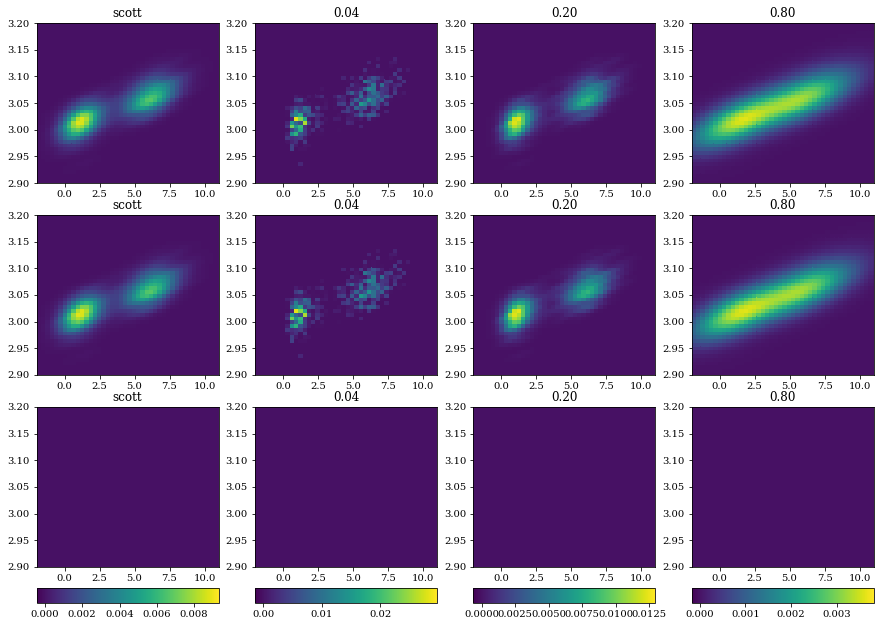

In [10]:
NUM = 1000
np.random.seed(1234)
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bb = np.random.normal(3.0, 0.02, NUM) + aa/100

data = [aa, bb]
edges = [kale.utils.spacing(dd, 'lin', 70, stretch=1.5) for dd in data]
cents = [kale.utils.midpoints(ee, 'lin') for ee in edges]
areas = np.diff(edges[0])[:, np.newaxis] * np.diff(edges[1])[:, np.newaxis]

xe, ye = np.meshgrid(*edges, indexing='ij')
xc, yc = np.meshgrid(*cents, indexing='ij')
grid = np.vstack([xc.ravel(), yc.ravel()])


methods = ['scott', 0.04, 0.2, 0.8]

fig, axes = plt.subplots(figsize=[15, 10], ncols=len(methods), nrows=3)
kde_funcs = [sp.stats.gaussian_kde, kale.KDE]

percs = sp.stats.norm.cdf([-1, 0, 1])
levels = sp.stats.norm.cdf([-2, -1, 1, 2])

for axcol, mm in zip(axes.T, methods):
    lab = mm if isinstance(mm, str) else "{:.2f}".format(mm)
    
    pdf_vals = []
    
    for kdefun in kde_funcs:
        hist, *_ = np.histogram2d(*data, bins=edges, density=True)

        kde = kdefun(data, bw_method=mm)
        pdf = areas * kde.pdf(grid).reshape(hist.shape).T

        pdf_vals.append(pdf)
        # tot = kale.utils.trapz_nd(pdf, cents)
        tot = np.sum(pdf)
        # print("{} : total = {:.4e}".format(kdefun, tot))
        kale.utils.allclose(tot, 1.0, rtol=3e-2)
        
    extr = kale.utils.minmax(pdf_vals, stretch=0.1)
    # print(extr)
    rat = np.zeros_like(pdf_vals[1])
    idx = (pdf_vals[0] > 0.0)
    # rat[idx] = pdf_vals[1][idx] / pdf_vals[0][idx]
    rat[idx] = (pdf_vals[1][idx] - pdf_vals[0][idx])  # / pdf_vals[1][idx]
    pdf_vals.append(rat)
    
    for ax, pdf in zip(axcol, pdf_vals):
        ax.set_title(lab)

        # ax.scatter(*data, facecolor='dodgerblue', edgecolor='b', alpha=0.1)
        # hist, *_ = np.histogram2d(*data, bins=edges, density=True)
        # ax.contour(xc, yc, hist.T, levels=levels, cmap='Blues')

        # ax.contour(xc, yc, pdf.T, levels=levels, cmap='Reds')
        pcm = ax.pcolormesh(xc, yc, pdf.T, vmin=extr[0], vmax=extr[1])        
        ax.set(xlim=[-2, 11], ylim=[2.9, 3.2])

    bbox = ax.get_window_extent(transform=fig.transFigure).transformed(fig.transFigure.inverted())
    rect = [bbox.x0, bbox.y0-0.05, bbox.width, 0.02]
    cbax = fig.add_axes(rect)
    plt.colorbar(pcm, cax=cbax, orientation='horizontal')
    
nbshow()

## Projections and Subsampling

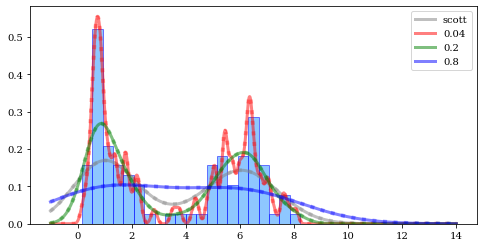

In [11]:
NUM = 100
a1 = np.random.normal(6.0, 1.0, NUM//2)
a2 = np.random.lognormal(0, 0.5, size=NUM//2)
aa = np.concatenate([a1, a2])

bins = kale.utils.spacing([-1, 14.0], 'lin', 40)
grid = kale.utils.spacing(bins, 'lin', 3000)

fig, ax = plt.subplots(figsize=[8, 4])
ax.hist(aa, bins=bins, facecolor='dodgerblue', edgecolor='b', alpha=0.5, density=True)

methods = ['scott', 0.04, 0.2, 0.8]
colors = ['0.5', 'r', 'g', 'b']
for mm, cc in zip(methods, colors):
    lab = mm if isinstance(mm, str) else "{:.1f}".format(mm)

    kde = kale.KDE(aa, bandwidth=mm)
    ax.plot(grid, kde.pdf(grid), color=cc, alpha=0.5, lw=3.0, label=mm)

    kde = sp.stats.gaussian_kde(aa, bw_method=mm)
    ax.plot(grid, kde.pdf(grid), color=cc, alpha=0.35, lw=4.0, ls=':')

plt.legend(loc='upper right')
nbshow()